In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append("../..")
from models import RNN

import sklearn.metrics as metrics
from scipy.optimize import minimize
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras import backend as K
import tensorflow.keras.utils as kutils

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

   accuracy  val_accuracy
0  0.469092      0.705085
1  0.500883      0.688136
2  0.597315      0.528814
3  0.606146      0.535593
4  0.522430      0.454237


Text(0, 0.5, 'Accuracy')

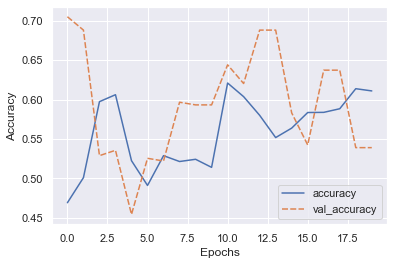

In [35]:
n_epochs = 20
n_models = 10
n_steps = 24
model_prefix = f"RNN-snapshot-{n_steps}-{n_epochs}"

raw_data = pd.read_csv(f'{model_prefix}.csv')
raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
print(raw_data.head())

sns.set_theme()
sns.lineplot(data=raw_data)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Ensemble snapshots and produce results 'over_time'


In [43]:
elec = pd.read_csv('../../data/electricity-normalized.csv')
X = elec.values[:,0:8].astype(np.float)
y = elec.values[:,8]
enc = OneHotEncoder(categories=[['DOWN', 'UP']])
y = enc.fit_transform(y.reshape(-1, 1)).toarray()
print(y.shape)

dataset_test = timeseries_dataset_from_array(X, y, sequence_length=n_steps, batch_size=int(0.3 * len(X)), start_index=int(0.7 * len(X)))
X_test, y_test = list(dataset_test)[0]

X_test = X_test.numpy()
y_test = y_test.numpy()

NUM_TESTS=25
nb_classes=2

(45312, 2)


In [44]:
snapshot_model = RNN.create_rnn_model(n_timesteps=n_steps, n_features=8, n_outputs=2)
snapshot_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

file_list =[f'./{model_prefix}/{model_prefix}-{j}-1.h5' for j in range(n_models)]

preds = []
for fn in file_list:
    snapshot_model.load_weights(fn)
    yPreds = snapshot_model.predict(X_test)
    preds.append(yPreds)

    print("Obtained predictions from model with weights = %s" % (fn))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 48)                10944     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 98        
Total params: 11,042
Trainable params: 11,042
Non-trainable params: 0
_________________________________________________________________
Obtained predictions from model with weights = ./RNN-snapshot-24-20/RNN-snapshot-24-20-0-1.h5
Obtained predictions from model with weights = ./RNN-snapshot-24-20/RNN-snapshot-24-20-1-1.h5
Obtained predictions from model with weights = ./RNN-snapshot-24-20/RNN-snapshot-24-20-2-1.h5
Obtained predictions from model with weights = ./RNN-snapshot-24-20/RNN-snapshot-24-20-3-1.h5
Obtained predictions from model with weights = ./RNN-snapshot-24-20/RNN-snapshot-24-20-4-1.h5
Obtained predictions from model with weigh

In [ ]:
print(preds[0]) 

In [49]:
def calculate_weighted_accuracy(prediction_weights):
    weighted_predictions = np.zeros((X_test.shape[0], nb_classes), dtype='float32')
    for weight, prediction in zip(prediction_weights, preds):
        weighted_predictions += weight * prediction
    yPred = enc.inverse_transform(weighted_predictions)
    yTrue = enc.inverse_transform(y_test)
    accuracy = metrics.accuracy_score(yTrue, yPred) * 100
    error = 100 - accuracy
    print("Accuracy: ", accuracy)
    print("Error: ", error)

In [46]:
# Create the loss metric
def log_loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = np.zeros((X_test.shape[0], nb_classes), dtype='float32')

    for weight, prediction in zip(weights, preds):
        final_prediction += weight * prediction

    return log_loss(y_test, final_prediction)

In [58]:
def get_accuracy_for_n_snapshots(n_snapshots):
    best_acc = 0.0
    best_weights = None

    # Parameters for optimization
    constraints = ({'type': 'eq', 'fun':lambda w: 1 - sum(w)})
    bounds = [(0, 1)] * n_snapshots

    # Check for NUM_TESTS times
    for iteration in range(NUM_TESTS):
        # Random initialization of weights
        prediction_weights = np.random.random(n_snapshots)
        
        # Minimise the loss 
        result = minimize(log_loss_func, prediction_weights, method='SLSQP', bounds=bounds, constraints=constraints)
        print('Best Ensemble Weights: {weights}'.format(weights=result['x']))
        
        weights = result['x']
        weighted_predictions = np.zeros((X_test.shape[0], nb_classes), dtype='float32')
        
        # Calculate weighted predictions
        for weight, prediction in zip(weights, preds[:n_snapshots]):
            weighted_predictions += weight * prediction

        yPred = enc.inverse_transform(weighted_predictions)
        yTrue = enc.inverse_transform(y_test)

        unique, counts = np.unique(yPred, return_counts=True)
        print(unique, counts)

        # Calculate weight prediction accuracy
        accuracy = metrics.accuracy_score(yTrue, yPred) * 100
        error = 100 - accuracy
        print("Iteration %d: Accuracy : " % (iteration + 1), accuracy)
        print("Iteration %d: Error : " % (iteration + 1), error)
        
        # Save current best weights 
        if accuracy > best_acc:
            best_acc = accuracy
            best_weights = weights
            
        print()

        return accuracy

In [59]:
results = []
for i in range(1, n_models + 1):
    # Compile list of units
    n_snapshots = i
    results.append(get_accuracy_for_n_snapshots(i))

Best Ensemble Weights: [1.]
['DOWN' 'UP'] [11378  2193]
Iteration 1: Accuracy :  53.64379927787193
Iteration 1: Error :  46.35620072212807

Best Ensemble Weights: [0.53371531 0.46628469]
['DOWN' 'UP'] [13263   308]
Iteration 1: Accuracy :  56.79021442782404
Iteration 1: Error :  43.20978557217596

Best Ensemble Weights: [5.82354498e-01 2.60115867e-04 4.17385387e-01]
['DOWN' 'UP'] [11687  1884]
Iteration 1: Accuracy :  54.47645715127846
Iteration 1: Error :  45.52354284872154

Best Ensemble Weights: [0.63472632 0.13097066 0.17971875 0.05458427]
['DOWN' 'UP'] [12092  1479]
Iteration 1: Accuracy :  55.58912386706949
Iteration 1: Error :  44.41087613293051

Best Ensemble Weights: [1.66533454e-16 3.78631199e-01 6.21368801e-01 0.00000000e+00
 5.55111512e-17]
['DOWN' 'UP'] [12989   582]
Iteration 1: Accuracy :  57.15864711517206
Iteration 1: Error :  42.84135288482794

Best Ensemble Weights: [3.58988453e-02 3.29321842e-01 5.48795828e-01 1.80399239e-15
 7.04155390e-02 1.55679457e-02]
['DOWN' '